In [28]:
from operator import index
import fastai;
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.medical.imaging import *
from IPython.display import display
from fastai.torch_core import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [3]:
def relu(inplace:bool=False, leaky:float=None):
    "Return a relu activation, maybe `leaky` and `inplace`."
    return nn.LeakyReLU(inplace=inplace, negative_slope=leaky) if leaky is not None else nn.ReLU(inplace=inplace)

def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = fastai.weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = fastai.spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)


In [184]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

def maxpooling():
    return nn.MaxPool2d(2, stride=2)

def create_model():
    model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Softmax(288, 2))
    return model

In [142]:
def test(data,learn):
    print("Number of examples in testing:", len(data.valid_ds))
    probs,targets = learn.get_preds()

    probs = np.argmax(probs, axis=1)
    correct = 0
    for idx, pred in enumerate(probs):
        if pred == targets[idx]:
            correct += 1
    accuracy = correct / len(probs)
    print(len(probs), correct, accuracy)
    
    np.set_printoptions(threshold=np.inf) 
    cm1 = confusion_matrix(targets, probs)
    print(cm1)

    sns.heatmap(cm1, xticklabels=['Predito Indeterminate+Atypical','Predito Typical'], yticklabels=['Indeterminate+Atypical','Typical'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    #sns.heatmap(cm1/np.sum(cm1), xticklabels=['Predito Typical', 'Predito Indeterminate+Atypical'], yticklabels=['Typical', 'Indeterminate+Atypical'], annot=True, fmt='.2%',annot_kws={'fontsize':22}, cmap="YlGnBu");
    true_neg, false_pos = cm1[0]
    false_neg, true_pos = cm1[1]
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)
    print("\n\n")
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 Score: {}'.format(f1))
    print("\n\n")

    y_true1 = targets
    y_pred1 = probs
    target_names = ['Indeterminate+Atypical', 'Typical']
    print(classification_report(y_true1, y_pred1, target_names=target_names))

    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.xticks(rotation=360)
    plt.show()
    #interp = ClassificationInterpretation.from_learner(learn)
    #cm_fig = interp.plot_confusion_matrix(return_fig=True)
    #ax = cm_fig.gca()
    #ax.set_ylim(interp.data.c - .5, - .5)



In [158]:
#source=Path("C:/Users/bruna/Documents/Bruna/Docs/Módulos/IADD/COVID-19-master/COVID-19-master/X-Ray Image DataSet/train_png/")
source=Path("C:/Users/bruna/Documents/Bruna/Docs/Módulos/IADD/train_png-20220620T010649Z-001/train_png/train_images")
files = os.listdir(source)
#print(files)

#df_typical = pd.read_csv(source/'images_labels_dataframe_covid.csv')
df_typical = pd.read_csv(source/'images_labels_dataframe_typical.csv')
print(df_typical.head())

#df_in_at = pd.read_csv(source/'images_labels_dataframe_no_findings.csv')
df_in_at = pd.read_csv(source/'images_labels_dataframe_i_a.csv')
print(df_in_at.head())

df = pd.concat([df_typical,df_in_at]).sample(frac=1,random_state=42).reset_index(drop=True)
df = df.drop(['Unnamed: 0'], axis=1)
print(df.head())

   Unnamed: 0          Filename    Class
0           0     Typical_0.png  Typical
1           1     Typical_1.png  Typical
2           2    Typical_10.png  Typical
3           3   Typical_100.png  Typical
4           4  Typical_1000.png  Typical
   Unnamed: 0                         Filename                   Class
0           0     Indeterminate+Atypical_0.png  Indeterminate+Atypical
1           1     Indeterminate+Atypical_1.png  Indeterminate+Atypical
2           2    Indeterminate+Atypical_10.png  Indeterminate+Atypical
3           3   Indeterminate+Atypical_100.png  Indeterminate+Atypical
4           4  Indeterminate+Atypical_1000.png  Indeterminate+Atypical
                          Filename                   Class
0                 Typical_1155.png                 Typical
1                 Typical_1428.png                 Typical
2                  Typical_709.png                 Typical
3                 Typical_2587.png                 Typical
4  Indeterminate+Atypical_1456.pn

In [180]:
blocks = (ImageBlock, CategoryBlock)
data_block = DataBlock(blocks=blocks,
                    getters = [ColReader('Filename', pref=source, suff=''), ColReader('Class')],
                    item_tfms = [Resize(224, 224)],
                    splitter  = RandomSplitter(valid_pct=0.2, seed=42)
                    )

dls = data_block.dataloaders(df, bs=64, num_workers=0)
print("Number of examples in training:", len(dls.train_ds))
print("Number of examples in validation:", len(dls.valid_ds))

xb,yb = dls.one_batch()
print(xb.shape,yb.shape)

Number of examples in training: 3503
Number of examples in validation: 875
torch.Size([64, 3, 224, 224]) torch.Size([64])


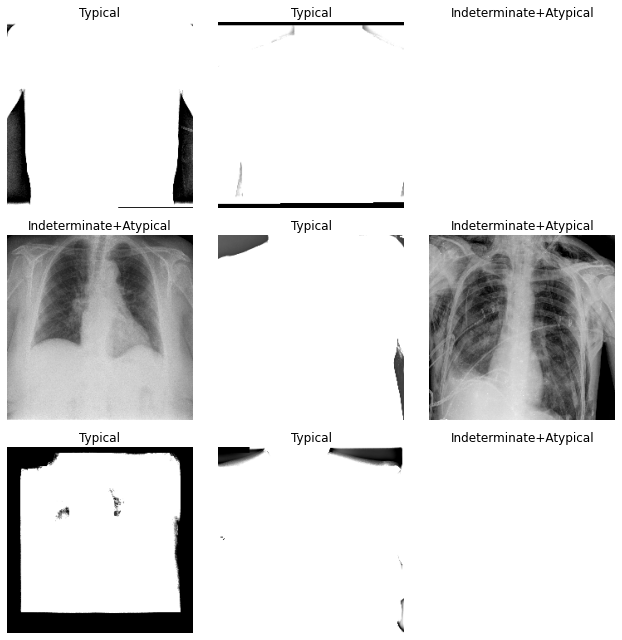

In [181]:
dls.train.show_batch()

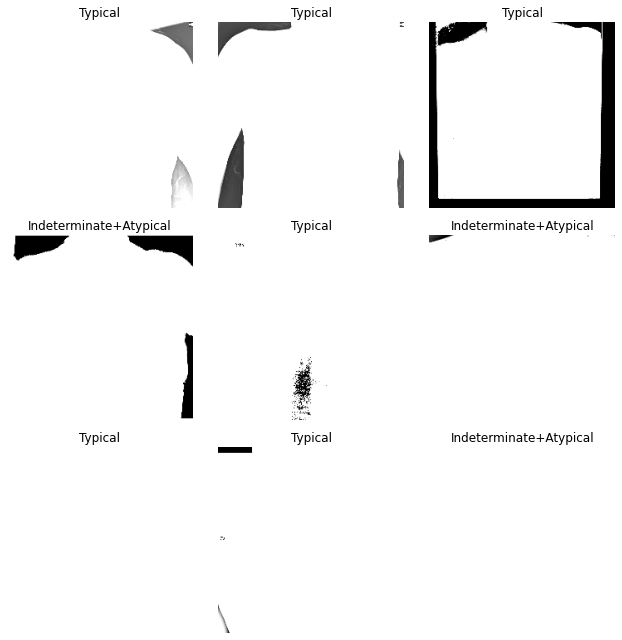

In [182]:
dls.valid.show_batch()

In [185]:
model = create_model()

learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy])
print(learn.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 224 x 224  
Conv2d                                    216        True      
BatchNorm2d                               16         True      
LeakyReLU                                                      
____________________________________________________________________________
                     64 x 8 x 112 x 112  
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 112 x 112 
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
LeakyReLU                                                      
____________________________________________________________________________
                     64 x 16 x 56 x 56   
MaxPool2d                                   

In [186]:
learn.fit_one_cycle(20,  lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.659995,0.662466,0.637714,01:57
1,0.649897,0.658453,0.634286,01:58
2,0.649678,0.709154,0.635429,02:03


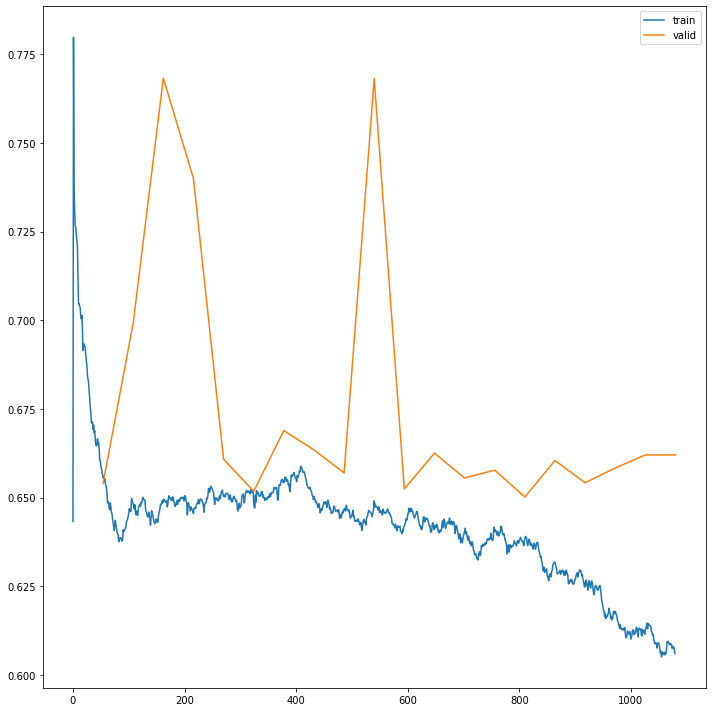

In [153]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [137]:
# Save the model
learn.save('C:/Users/bruna/Documents/Bruna/Docs/Módulos/IADD/Projeto/models/model_270622_64_16')

Path('C:/Users/bruna/Documents/Bruna/Docs/Módulos/IADD/Projeto/models/model_270622_64_16.pth')

In [143]:
# Load the Model
learn.load('C:/Users/bruna/Documents/Bruna/Docs/Módulos/IADD/Projeto/models/model_270622_64_20')

In [144]:
# Unfreeze all layers of the CNN
learn.unfreeze()

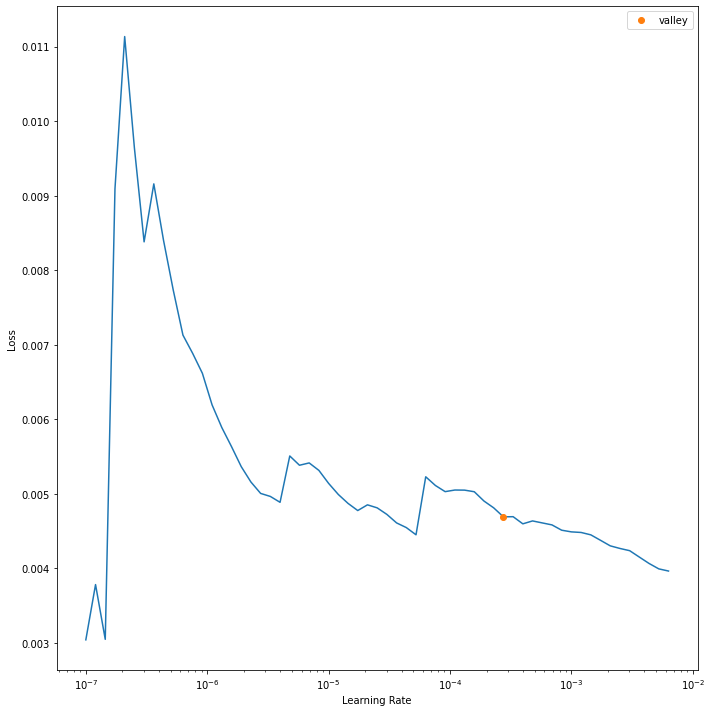

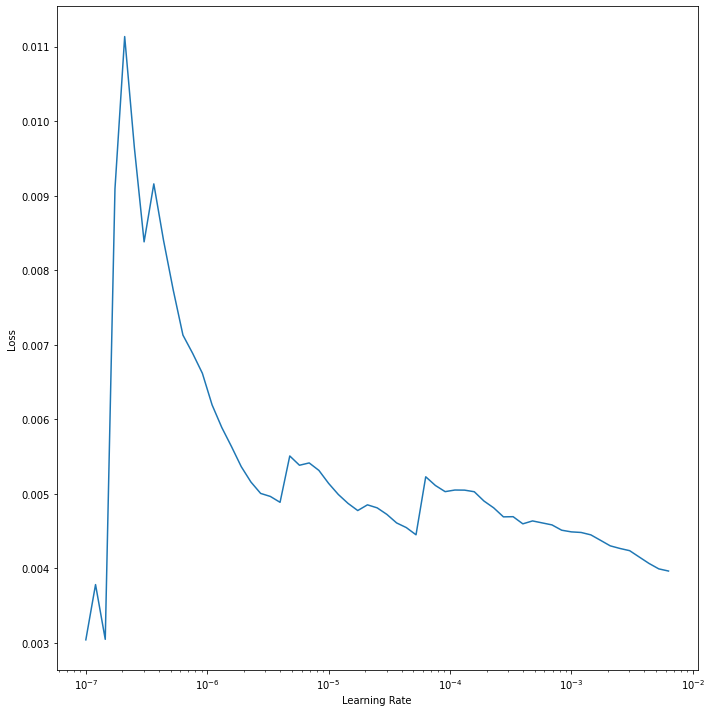

In [92]:
# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot_lr_find()

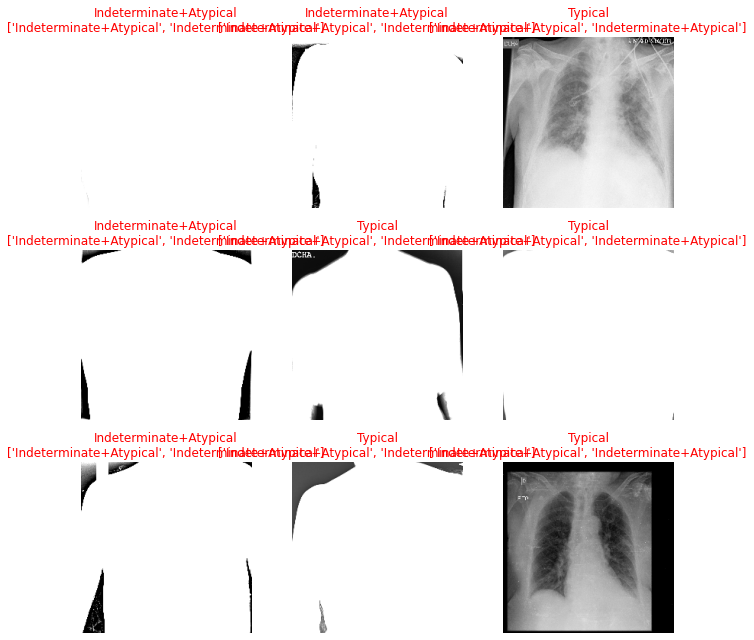

In [145]:
learn.show_results()

Number of examples in testing: 875


875 554 0.6331428571428571
[[ 30 287]
 [ 34 524]]



Accuracy: 0.633
Precision: 0.646
Recall: 0.939
F1 Score: 0.765



                        precision    recall  f1-score   support

Indeterminate+Atypical       0.47      0.09      0.16       317
               Typical       0.65      0.94      0.77       558

              accuracy                           0.63       875
             macro avg       0.56      0.52      0.46       875
          weighted avg       0.58      0.63      0.55       875



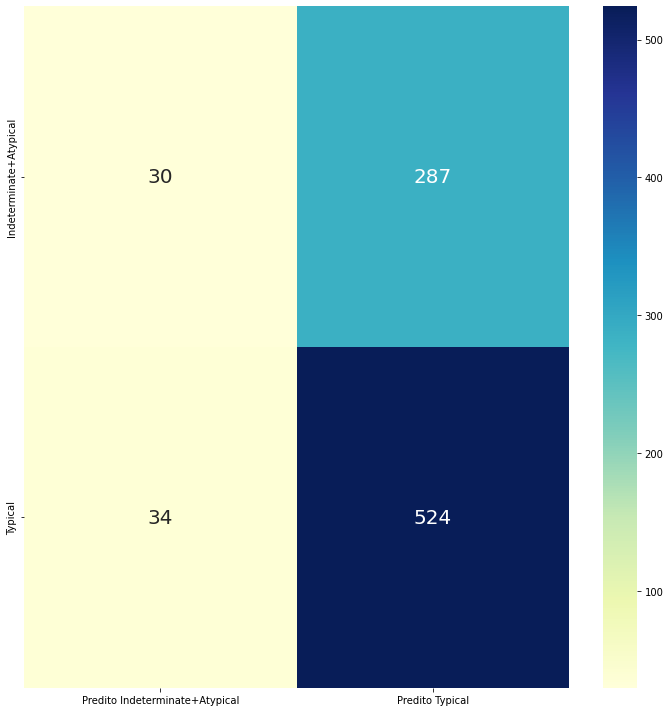

In [146]:
test(dls,learn)